## Lung Cancer Detection

In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Loading and Working on the Dataset

In [2]:
# Load Dataset
data_dir = "lung-cancer-data"

In [3]:
# extra code to save the figures as high-res PNGs for the book
from pathlib import Path

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

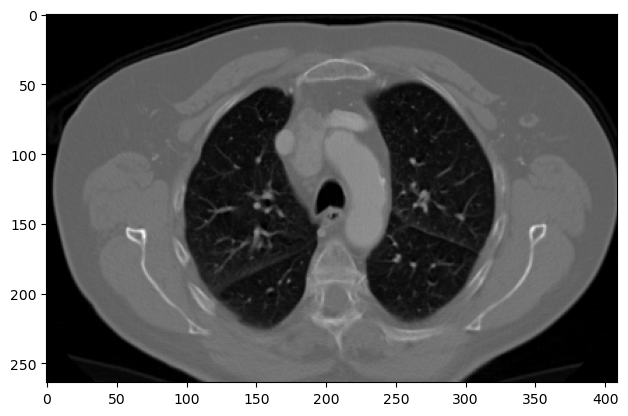

In [5]:
import matplotlib.image as mping
test_image = "lung-cancer-data/adenocarcinoma/000000 (6).png"
img = mping.imread(test_image)
plt.imshow(img)
save_fig("sample_adenocarcinoma")

In [6]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [8]:
# Splitting the dataset into training and validation sets

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 900 files belonging to 4 classes.
Using 720 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 900 files belonging to 4 classes.
Using 180 files for validation.


In [10]:
# class names

class_names = train_ds.class_names
class_names

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

## Data Visualization

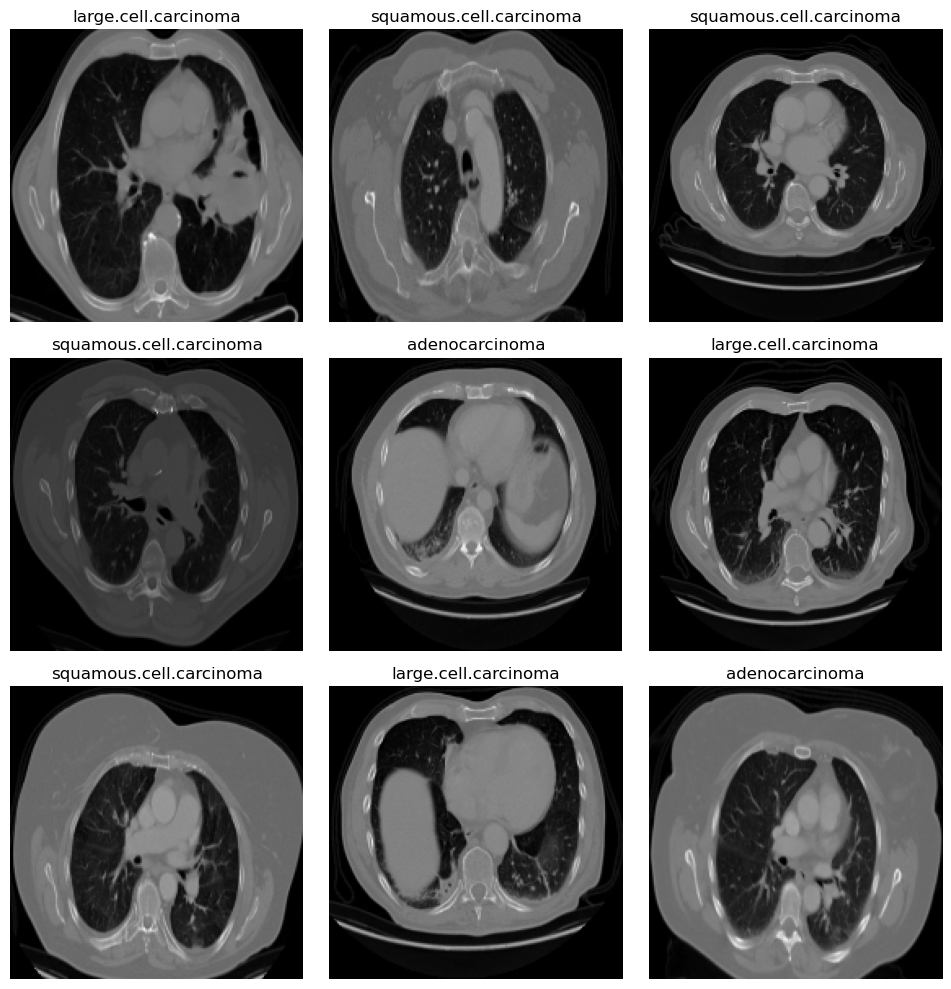

In [13]:
# Here are the first nine images from the training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        save_fig("sample_training_images")

In [14]:
# manually iterate over the dataset and retreive batches of images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The image_batch is tensor of shape (32,180,180,3). This is a batch of size(180*180*3), the last dimension refers to color channelsRGB). the labels_batch is a tensor of shape(32), these are the corresponding labels to the 32 images

## Configure the Dataset for Performance

Dataset.cache - keeps the images in memory after they are loaded off disk during the first epoch.

Dataset.prefetch - overlaps data preprocessing and model execution while trainig

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)